# Preprocessing

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)

In [2]:
df = pd.concat([pd.read_csv(f'../../../../data/F_feature_selection/feature_selection-{year}.csv', sep=';') for year in [2019, 2020, 2021, 2022]])
df_test = pd.read_csv('../../../../data/F_feature_selection/feature_selection-2023.csv', sep=';')

In [3]:
columns_to_drop = [
    'latitude', 'longitude',
    'pedestrian_location', 'pedestrian_action',
    'hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'day_of_year_sin', 'day_of_year_cos', 'age',
    'direction_of_travel_other'
]

object_type = ['role', 'age_group', 'vehicle_category_simplified', 'vehicle_category_simplified_other', 'time_of_day']

na_with_meaning = [
    'fixed_obstacle_struck', 'mobile_obstacle_struck', 'initial_point_of_impact', 'main_maneuver_before_accident', 'motor_type',
    'fixed_obstacle_struck_other', 'mobile_obstacle_struck_other', 'initial_point_of_impact_other', 'main_maneuver_before_accident_other', 'motor_type_other',
    'sex'
]

columns_to_int32 = [
    'location', 'type_of_collision', 'reserved_lane_present', 'horizontal_alignment', 'infrastructure', 'accident_situation', 'position',
    'fixed_obstacle_struck', 'mobile_obstacle_struck', 'initial_point_of_impact', 'main_maneuver_before_accident', 'motor_type', 
    'fixed_obstacle_struck_other', 'mobile_obstacle_struck_other', 'initial_point_of_impact_other', 'main_maneuver_before_accident_other',
    'motor_type_other','vehicle_category_involved_bicycle', 'vehicle_category_involved_bus_coach', 'vehicle_category_involved_hgv_truck',
    'vehicle_category_involved_light_motor_vehicle', 'vehicle_category_involved_other', 'vehicle_category_involved_powered_2_3_wheeler',
    'used_belt', 'used_helmet', 'used_child_restraint', 'used_airbag', 'impact_score', 'impact_score_other', 'impact_delta', 'surface_quality_indicator',
    'lighting_ordinal', 'weather_ordinal', 'injury_target', 'sex', 'day_of_week', 'speed_limit'
]

In [4]:
for x in [df, df_test]:
    # Remove rows or columns with missing values that do not encode info.
    x.drop(columns=columns_to_drop, inplace=True)    
    x.replace(-1, pd.NA, inplace=True)
    x[na_with_meaning] = x[na_with_meaning].fillna(-1)
    x[['vehicle_category_simplified', 'vehicle_category_simplified_other']] = x[['vehicle_category_simplified', 'vehicle_category_simplified_other']].fillna('no vehicle')
    x.dropna(inplace=True)
    x[columns_to_int32] = x[columns_to_int32].astype('int32')
    
    # Drop rows with impossible speed limit
    # France has a maximum speed limit of 130
    x.drop(index=x[x['speed_limit'] > 130].index, inplace=True)
 

/tmp/ipykernel_4673/4081092471.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x[na_with_meaning] = x[na_with_meaning].fillna(-1)
/tmp/ipykernel_4673/4081092471.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x[na_with_meaning] = x[na_with_meaning].fillna(-1)


In [5]:
num_cols = ['speed_limit', 'day_of_week', 'impact_score', 'impact_score_other', 'impact_delta', 'road_complexity_index', 'surface_quality_indicator', 'lighting_ordinal', 'weather_ordinal']
cat_cols = df.columns.difference(num_cols + ['injury_target'])

In [6]:
X_train = df.drop(columns='injury_target')
y_train = df['injury_target']

X_test = df_test.drop(columns='injury_target')
y_test = df_test['injury_target']

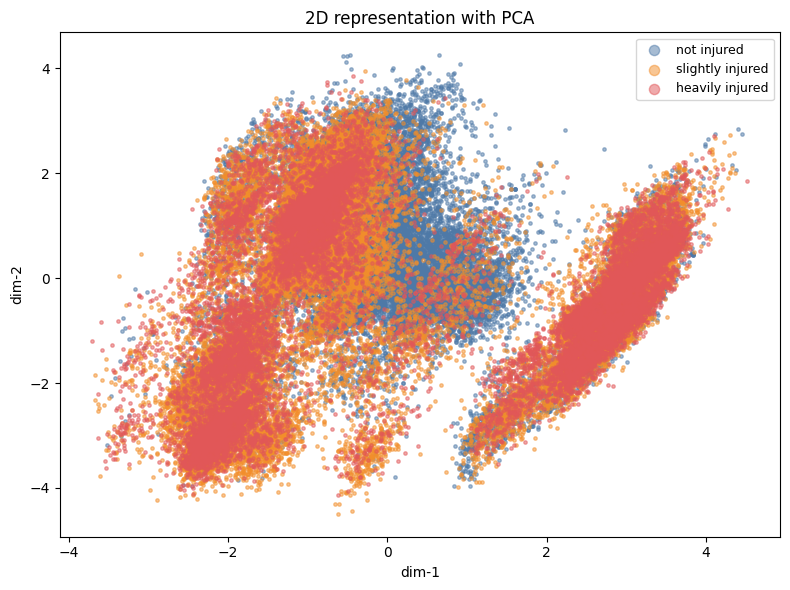

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler


# Build preprocessing to numeric space
pre = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False), [c for c in X_train.columns if c not in num_cols]),
    ('num', StandardScaler(), num_cols),
], remainder='drop')

X_train_num = pre.fit_transform(X_train, y_train)

# Choose method: 'pca', 'tsne'
method = 'pca'  # change to 'tsne' or 'umap' as needed
rs = 42

if method == 'pca':
    reducer = PCA(n_components=2, random_state=rs)
    Z = reducer.fit_transform(X_train_num)
elif method == 'tsne':
    # t-SNE can be slow; consider subsampling for very large datasets
    reducer = TSNE(n_components=2, perplexity=30, learning_rate='auto', init='pca', random_state=rs, verbose=0, n_jobs=-1)
    Z = reducer.fit_transform(X_train_num)
else:
    raise ValueError("Set method to 'pca', 'tsne', or 'umap' (install umap-learn).")

# Optional: subsample for plotting speed
max_points = 100000
if Z.shape[0] > max_points:
    rng = np.random.RandomState(rs)
    idx = rng.choice(Z.shape[0], size=max_points, replace=False)
    Zp = Z[idx]
    yp = y_train.iloc[idx].to_numpy()
else:
    Zp = Z
    yp = y_train.to_numpy()

# Prepare a small helper for labels/colors
label_names = {0:'not injured', 1:'slightly injured', 2:'heavily injured'}
colors = {0:'#4e79a7', 1:'#f28e2b', 2:'#e15759'}

plt.figure(figsize=(8, 6))
for k in sorted(np.unique(yp)):
    m = (yp == k)
    plt.scatter(Zp[m, 0], Zp[m, 1], s=6, alpha=0.5, c=colors.get(k, '#888888'), label=label_names.get(k, str(k)))
plt.title(f'2D representation with {method.upper()}')
plt.xlabel('dim-1')
plt.ylabel('dim-2')
plt.legend(markerscale=3, fontsize=9, frameon=True)
plt.tight_layout()
plt.show()

# Keep for later use if needed
embed_2d = pd.DataFrame({'x': Z[:, 0], 'y': Z[:, 1], 'label': y_train.to_numpy()})

In [ ]:
# Autoencoder -> 3D latent embedding

import numpy as np
import pandas as pd

# Ensure we have numeric matrix and labels (re-use your preprocessing)
# X_all_num: numeric array from ColumnTransformer
# y_all: labels concatenated from train/test
# assert 'X_all_num' in globals() and 'y_all' in globals(), "Run the preprocessing cell that builds X_all_num and y_all first."

# Install/import TF before this cell; restart kernel after installing GPU support.
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers, callbacks
from tensorflow.keras import mixed_precision


# Build preprocessing to numeric space
pre = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False), [c for c in X_train.columns if c not in num_cols]),
    ('num', StandardScaler(), num_cols),
], remainder='drop')

X_train_num = pre.fit_transform(X_train, y_train)


print('TF:', tf.__version__, 'Built with CUDA:', tf.test.is_built_with_cuda())
gpus = tf.config.list_physical_devices('GPU')
print('GPUs:', gpus)
for gpu in gpus:
    try:
        tf.config.experimental.set_memory_growth(gpu, True)
    except Exception as e:
        print('Memory growth not set:', e)

# Mixed precision (speeds up on modern GPUs)
mixed_precision.set_global_policy('mixed_float16')

tf.random.set_seed(42)
np.random.seed(42)

Xn = X_train_num.astype('float32')
input_dim = Xn.shape[1]

# Encoder
inp = keras.Input(shape=(input_dim,), name='inp')
x = layers.Dense(input_dim, activation='relu', kernel_regularizer=regularizers.l2(1e-3))(inp)
x = layers.BatchNormalization()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.BatchNormalization()(x)
latent = layers.Dense(3, name='latent')(x)  # stays float16 under policy

# Decoder
x = layers.Dense(64, activation='relu')(latent)
x = layers.Dense(input_dim, activation='relu')(x)

# IMPORTANT: final layer to float32 for stable MSE when using mixed precision
out = layers.Dense(input_dim, activation='linear', dtype='float32', name='recon')(x)

encoder = keras.Model(inp, latent, name='encoder')
autoenc = keras.Model(inp, out, name='autoencoder')

# Use CUDA + XLA JIT
autoenc.compile(optimizer=keras.optimizers.Adam(1e-3), loss='mse', jit_compile=True)

es = callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
rlrop = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

with tf.device('/GPU:0'):
    hist = autoenc.fit(
        Xn, Xn,
        epochs=100,
        batch_size=3000,   # raise if VRAM allows, lower if OOM
        shuffle=True,
        validation_split=0.1,
        callbacks=[es, rlrop],
        verbose=1
    )

with tf.device('/GPU:0'):
    Z = encoder.predict(Xn, batch_size=4096)
Z = Z.astype('float32')

# Optional: subsample for plotting speed
rs = 42
max_points = 100000
if Z.shape[0] > max_points:
    rng = np.random.RandomState(rs)
    idx = rng.choice(Z.shape[0], size=max_points, replace=False)
    Zp = Z[idx]
    yp = y_train.iloc[idx].to_numpy()
else:
    Zp = Z
    yp = y_train.to_numpy()

# Matplotlib 3D scatter
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
import matplotlib.pyplot as plt

label_names = {0:'not injured', 1:'slightly injured', 2:'heavily injured'}
colors = {0:'#4e79a7', 2:'#f28e2b', 3:'#e15759'}

fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111, projection='3d')
for k in sorted(np.unique(yp)):
    m = (yp == k)
    ax.scatter(Zp[m, 0], Zp[m, 1], Zp[m, 2], s=6, alpha=0.5,
               c=colors.get(k, '#888888'), label=label_names.get(k, str(k)))

ax.set_title('3D representation with Autoencoder')
ax.set_xlabel('z1'); ax.set_ylabel('z2'); ax.set_zlabel('z3')
ax.view_init(elev=30, azim=45)
ax.legend(markerscale=3, fontsize=9, frameon=True)
plt.tight_layout()
plt.show()

# Optional Plotly (interactive rotate)
import plotly.express as px
df_plot = pd.DataFrame({'x': Zp[:,0], 'y': Zp[:,1], 'z': Zp[:,2], 'label': yp})
df_plot['label_name'] = df_plot['label'].map(label_names)
fig = px.scatter_3d(df_plot, x='x', y='y', z='z', color='label_name',
                    color_discrete_map={'not injured': colors[1], 'slightly injured': colors[2],
                                       'heavily injured': colors[3], 'killed': colors[4]},
                    opacity=0.6)
fig.update_traces(marker=dict(size=2))
fig.update_layout(title='3D representation with Autoencoder')
fig.show()

# Save embedding for later use
embed_3d_ae = pd.DataFrame({'x': Z[:,0], 'y': Z[:,1], 'z': Z[:,2], 'label': y_train.to_numpy()})

TF: 2.20.0 Built with CUDA: True
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


I0000 00:00:1762719151.590233    4673 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1768 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
2025-11-09 21:12:36.547293: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 378430692 exceeds 10% of free system memory.
2025-11-09 21:12:37.087123: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 378430692 exceeds 10% of free system memory.
2025-11-09 21:12:37.615369: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 378430692 exceeds 10% of free system memory.
2025-11-09 21:12:37.749638: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 378430692 exceeds 10% of free system memory.


Epoch 1/100


2025-11-09 21:12:43.122937: I external/local_xla/xla/service/service.cc:163] XLA service 0x7f4b70033cb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-09 21:12:43.122986: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2025-11-09 21:12:44.397848: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-09 21:12:46.152761: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91500
2025-11-09 21:12:51.248010: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_247', 176 bytes spill stores, 176 bytes spill loads

2025-11-09 21:12:51.386632: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc

  5/126 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.1165

I0000 00:00:1762719183.252307    5010 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


122/126 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0775

2025-11-09 21:13:07.322654: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_247', 176 bytes spill stores, 176 bytes spill loads

2025-11-09 21:13:07.400242: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_772', 412 bytes spill stores, 592 bytes spill loads

2025-11-09 21:13:07.518884: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_512', 564 bytes spill stores, 420 bytes spill loads

2025-11-09 21:13:07.813792: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_247', 16 bytes spill stores, 16 bytes spill loads

2025-11-09 21:13:08.313982: I external

126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 0.0769

2025-11-09 21:15:59.091920: E external/local_xla/xla/service/slow_operation_alarm.cc:73] 
********************************
[Compiling module gemm_fusion_dot.64] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2025-11-09 21:15:59.824752: E external/local_xla/xla/service/slow_operation_alarm.cc:73] 
********************************
[Compiling module gemm_fusion_dot.64] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2025-11-09 21:16:00.539030: E external/local_xla/xla/service/slow_operation_alarm.cc:73] 
********************************
[Compiling module gemm_fusion_dot.77] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2025-11-09 21:16:01.603843: E external/local_xla/xla/service/

: 